# IMDB Sentiment Analysis with Pre-trained Transformer (DistilBERT)

Simple approach using Hugging Face Transformers.

## 1. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import tensorflow as tf
import tf_keras
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

print(f"TensorFlow: {tf.__version__}")
print(f"GPUs: {len(tf.config.list_physical_devices('GPU'))}")

2025-12-13 21:25:15.342584: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-13 21:25:15.454272: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-13 21:25:24.693330: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow: 2.20.0
GPUs: 1


## 2. Hyperparameters

In [2]:
# Model
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 512
DROPOUT = 0.15  # Tuned: was 0.1
ATTENTION_DROPOUT = 0.1  # Tuned: was 0.1

# Training
LEARNING_RATE = 1.7617e-05  # Tuned: was 2e-05
BATCH_SIZE = 8  # Tuned: was 16
EPOCHS = 3
TEST_SIZE = 0.2

# Tuned hyperparameters - Best val_accuracy: 0.9198
WEIGHT_DECAY = 0.01

## 3. Load Data

In [3]:
dataset = pd.read_csv('data/imdb_dataset.csv')
train_df, test_df = train_test_split(dataset, test_size=TEST_SIZE, random_state=42)

y_train = (train_df['sentiment'] == 'positive').astype(int).values
y_test = (test_df['sentiment'] == 'positive').astype(int).values

print(f"Train: {len(train_df)}, Test: {len(test_df)}")

Train: 40000, Test: 10000


## 4. Tokenize

In [4]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

X_train = tokenizer(
    train_df['review'].tolist(),
    max_length=MAX_LEN,
    truncation=True,
    padding=True,
    return_tensors='tf'
)

X_test = tokenizer(
    test_df['review'].tolist(),
    max_length=MAX_LEN,
    truncation=True,
    padding=True,
    return_tensors='tf'
)

print("Tokenization complete")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
I0000 00:00:1765654019.046634   93436 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5518 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Tokenization complete


## 5. Load Pre-trained Model

In [5]:
model = TFDistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    use_safetensors=False,
    dropout=DROPOUT,
    attention_dropout=ATTENTION_DROPOUT
)

# Use AdamW optimizer with weight decay
optimizer = tf_keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

model.compile(
    optimizer=optimizer,
    loss=tf_keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("Model loaded")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-

Model loaded


## 6. Train

In [6]:
start = time.time()

history = model.fit(
    {'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(
        {'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}, 
        y_test
    ),
    verbose=1  # Show progress bar with detailed info
)

print(f"\nTime: {time.time() - start:.1f}s")

Epoch 1/3


2025-12-13 21:27:26.943969: I external/local_xla/xla/service/service.cc:163] XLA service 0x7678f13967e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-13 21:27:26.944002: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-12-13 21:27:26.949537: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-13 21:27:26.969237: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
I0000 00:00:1765654047.021851   93538 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5000/5000 [==============================] - 1415s 280ms/step - loss: 0.2351 - accuracy: 0.9064 - val_loss: 0.1841 - val_accuracy: 0.9283
Epoch 2/3
5000/5000 [==============================] - 1387s 277ms/step - loss: 0.1373 - accuracy: 0.9508 - val_loss: 0.1800 - val_accuracy: 0.9299
Epoch 3/3
5000/5000 [==============================] - 1385s 277ms/step - loss: 0.0771 - accuracy: 0.9736 - val_loss: 0.2104 - val_accuracy: 0.9339

Time: 4187.1s


## 7. Results

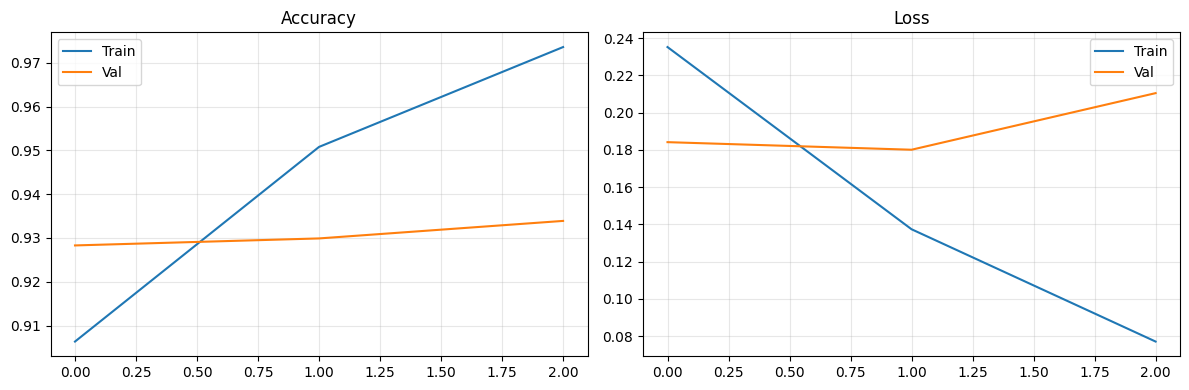

1250/1250 [==============================] - 93s 74ms/step - loss: 0.2104 - accuracy: 0.9339

Test Accuracy: 0.9339
Test Loss: 0.2104


In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Val')
ax1.set_title('Accuracy')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Val')
ax2.set_title('Loss')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluate
loss, acc = model.evaluate(
    {'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},
    y_test,
    batch_size=BATCH_SIZE
)

print(f"\n{'='*50}")
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Loss: {loss:.4f}")
print(f"{'='*50}")

## 8. Confusion Matrix

1250/1250 [==============================] - 92s 73ms/step


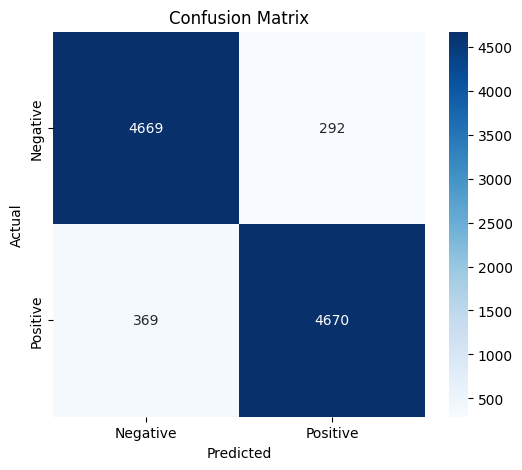

In [8]:
predictions = model.predict(
    {'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},
    batch_size=BATCH_SIZE
)

y_pred = np.argmax(predictions.logits, axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 9. Test Predictions

In [9]:
def predict(text):
    inputs = tokenizer(text, max_length=MAX_LEN, truncation=True, padding=True, return_tensors='tf')
    outputs = model(inputs)
    probs = tf.nn.softmax(outputs.logits, axis=1).numpy()[0]
    sentiment = "Positive" if probs[1] > probs[0] else "Negative"
    return probs[1], sentiment

tests = [
    "This was the best movie I have ever seen!",
    "I really hated this film. It was slow and boring.",
    "The acting was decent, but the plot was weak.",
    "Absolutely brilliant and stunning!"
]

print("Test Predictions:\n" + "="*60)
for text in tests:
    score, sentiment = predict(text)
    print(f"{text}")
    print(f"→ {score:.4f} ({sentiment})\n")

Test Predictions:
This was the best movie I have ever seen!
→ 0.9939 (Positive)

I really hated this film. It was slow and boring.
→ 0.0015 (Negative)

The acting was decent, but the plot was weak.
→ 0.0594 (Negative)

Absolutely brilliant and stunning!
→ 0.9976 (Positive)

